In [1]:
import pandas as pd
from sklearn import linear_model
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import PolynomialFeatures
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
import geopandas
from matplotlib import pyplot as plt
import matplotlib
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.decomposition import PCA
from statistics import mean


/home/gautam/.local/lib/python3.6/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
df = pd.read_csv("../dataset/ML_5yr_dataset.csv")

In [3]:
df = df[df["Install_year"].notnull()].copy()

In [4]:
df["age"]=df["year"]-df["Install_year"]
df["years_since_break"]=df["year"]-df["last_break_yr"]

In [5]:
xcols = ["Install_year","CI","DI","SPUN","SAND","years_since_break","prior_breaks","age"]
ycol = "y"
df[ycol] = df[ycol].astype(int)
X_train, X_test, y_train, y_test = train_test_split(df[xcols], df[ycol], test_size=0.2, random_state = 63)

In [6]:
scores=[]
min_cross_val=[]
max_cross_val=[]
training=[]

In [7]:
col=["years_since_break","prior_breaks"]
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("lr",LogisticRegression())
])
pipe.fit(X_train[col],y_train)
scores.append(mean(cross_validate(pipe, X_train[col], y_train, cv=12)["test_score"])*100)
min_cross_val.append(min(cross_validate(pipe, X_train[col], y_train, cv=12)["test_score"])*100)
max_cross_val.append(max(cross_validate(pipe, X_train[col], y_train, cv=12)["test_score"])*100)
training.append("LogR \n Years since Break, Prior Breaks")

In [8]:
col=xcols
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("lr",LogisticRegression())
])
pipe.fit(X_train[col],y_train)
scores.append(mean(cross_validate(pipe, X_train[col], y_train, cv=12)["test_score"])*100)
min_cross_val.append(min(cross_validate(pipe, X_train[col], y_train, cv=12)["test_score"])*100)
max_cross_val.append(max(cross_validate(pipe, X_train[col], y_train, cv=12)["test_score"])*100)
training.append("LogR \n All Features")

In [9]:
col=xcols
poly=xcols

pipe = Pipeline([
                ("poly", PolynomialFeatures(degree=2,include_bias=False)),
                ("scaler",StandardScaler()),
                ("lr", LogisticRegression(max_iter=200)),
                ])
pipe.fit(X_train[col],y_train)
scores.append(mean(cross_validate(pipe, X_train[col], y_train, cv=12)["test_score"])*100)
min_cross_val.append(min(cross_validate(pipe, X_train[col], y_train, cv=12)["test_score"])*100)
max_cross_val.append(max(cross_validate(pipe, X_train[col], y_train, cv=12)["test_score"])*100)
training.append("2 Degree Poly LogR \n All Features")

In [10]:
coef = list(pipe["lr"].coef_[0])
names = pipe["poly"].get_feature_names(input_features=xcols)
df=pd.DataFrame(coef,index=names,columns=["coef"])
df=df.sort_values("coef")

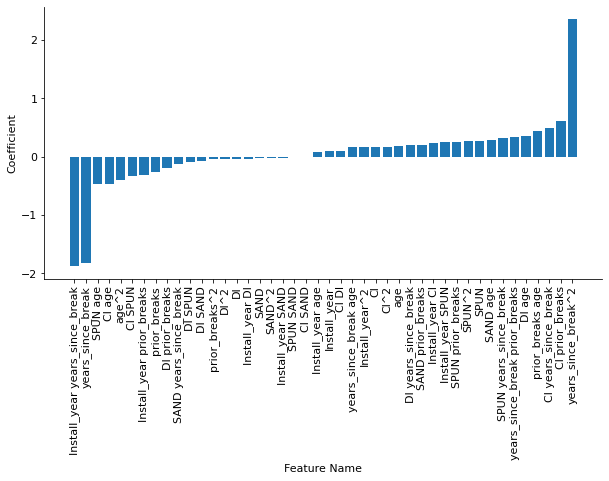

In [25]:
matplotlib.rcParams.update({'font.size': 11})
_,ax = plt.subplots(figsize=(10,5))

ax.bar(df.index,df["coef"])
ax.set_ylabel('Coefficient')
ax.set_xlabel('Feature Name')

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.xticks(rotation=90)
plt.autoscale()
plt.savefig("coef.png",bbox_inches="tight")

In [12]:
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
col=xcols
pipe = Pipeline([ 
    ("scaler",StandardScaler()),
    ("clf",clf),
])
pipe.fit(X_train[col],y_train)
scores.append(mean(cross_validate(pipe, X_train[col], y_train, cv=12)["test_score"])*100)
min_cross_val.append(min(cross_validate(pipe, X_train[col], y_train, cv=12)["test_score"])*100)
max_cross_val.append(max(cross_validate(pipe, X_train[col], y_train, cv=12)["test_score"])*100)
training.append("DT \n All Features")
pipe.score(X_test[col],y_test)

0.8582183186951067

In [13]:
clf = DecisionTreeClassifier(random_state=0,min_samples_leaf=85)
col=xcols
pipe = Pipeline([
    ("scaler",StandardScaler()),
    ("clf",clf),
])
pipe.fit(X_train[col],y_train)
scores.append(mean(cross_validate(pipe, X_train[col], y_train, cv=12)["test_score"])*100)
min_cross_val.append(min(cross_validate(pipe, X_train[col], y_train, cv=12)["test_score"])*100)
max_cross_val.append(max(cross_validate(pipe, X_train[col], y_train, cv=12)["test_score"])*100)
training.append("DT \n All Features \n Min Sample Leaf: 85")
pipe.score(X_test[col],y_test)

0.7779171894604768

In [14]:
print(clf.tree_.max_depth)


11


In [15]:
difference=[]
zip_object = zip(min_cross_val,max_cross_val)
for list1_i, list2_i in zip_object:
    difference.append((list2_i-list1_i)/2)

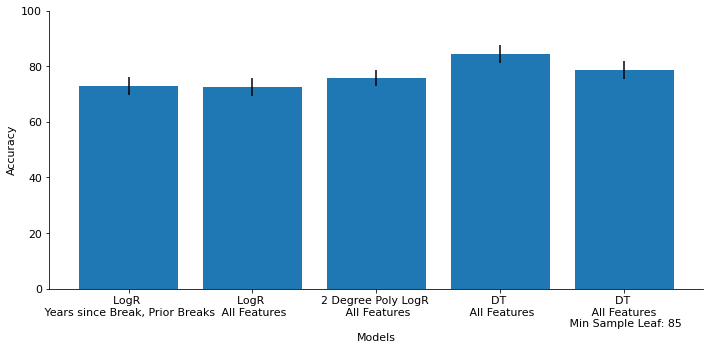

In [16]:
matplotlib.rcParams.update({'font.size': 11})
_,ax = plt.subplots(figsize=(10,5))

ax.bar(training,scores,yerr=difference)
ax.set_ylim(0,100)
ax.set_ylabel('Accuracy')
ax.set_xlabel('Models')

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.tight_layout()
plt.savefig("model_comparison.png")

[Text(125.55000000000001, 190.26, 'X[5] <= -0.938\ngini = 0.464\nsamples = 3187\nvalue = [2020, 1167]'),
 Text(83.7, 135.9, 'gini = 0.0\nsamples = 429\nvalue = [0, 429]'),
 Text(167.4, 135.9, 'X[6] <= 0.548\ngini = 0.392\nsamples = 2758\nvalue = [2020, 738]'),
 Text(83.7, 81.53999999999999, 'X[6] <= -0.461\ngini = 0.342\nsamples = 2334\nvalue = [1823, 511]'),
 Text(41.85, 27.180000000000007, '\n  (...)  \n'),
 Text(125.55000000000001, 27.180000000000007, '\n  (...)  \n'),
 Text(251.10000000000002, 81.53999999999999, 'X[6] <= 1.557\ngini = 0.497\nsamples = 424\nvalue = [197, 227]'),
 Text(209.25, 27.180000000000007, '\n  (...)  \n'),
 Text(292.95, 27.180000000000007, '\n  (...)  \n')]

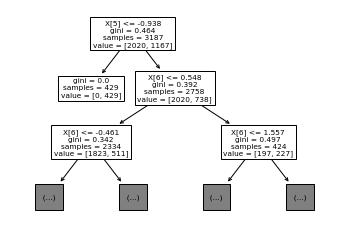

In [17]:
from sklearn import tree
tree.plot_tree(clf,max_depth=2)

In [18]:
from sklearn.tree import export_text
clf = DecisionTreeClassifier(max_depth=5)
clf.fit(X_train[xcols],y_train)
r = export_text(clf, feature_names=xcols)
print(r)

|--- years_since_break <= 0.50
|   |--- class: 1
|--- years_since_break >  0.50
|   |--- prior_breaks <= 4.50
|   |   |--- prior_breaks <= 1.50
|   |   |   |--- Install_year <= 1939.00
|   |   |   |   |--- age <= 69.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- age >  69.50
|   |   |   |   |   |--- class: 0
|   |   |   |--- Install_year >  1939.00
|   |   |   |   |--- Install_year <= 1946.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- Install_year >  1946.50
|   |   |   |   |   |--- class: 0
|   |   |--- prior_breaks >  1.50
|   |   |   |--- Install_year <= 1973.17
|   |   |   |   |--- age <= 42.75
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- age >  42.75
|   |   |   |   |   |--- class: 0
|   |   |   |--- Install_year >  1973.17
|   |   |   |   |--- age <= 27.33
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- age >  27.33
|   |   |   |   |   |--- class: 1
|   |--- prior_breaks >  4.50
|   |   |--- Install_year <= 1967.00
|   |   |   |--- prior_br

In [19]:
training

['LogR \n Years since Break, Prior Breaks',
 'LogR \n All Features',
 '2 Degree Poly LogR \n All Features',
 'DT \n All Features',
 'DT \n All Features \n Min Sample Leaf: 85']

In [20]:
scores

[72.76552229630681,
 72.54586939045727,
 75.80874355700573,
 84.4059441055469,
 78.53903626992008]